In [2]:
import numpy as np
import pandas as pd

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)

### Data Preprocessing

In [3]:
raw_df = pd.read_csv('spotify_tracks_dataset.csv')
raw_df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [136]:
df = raw_df.copy()

# Remove null row
df.dropna(inplace=True)

# Remove "Unnamed: 0" field, and remove any duplicate tracks
df = df.drop(columns = ["Unnamed: 0"])
df = df.drop_duplicates()

# Keep tracks with only 1 labeled genre
num_tracks_ids = df['track_id'].value_counts()
single_tracks_ids = num_tracks_ids[num_tracks_ids==1].index.tolist()
df = df[df['track_id'].isin(single_tracks_ids)]
print(df.shape)

(73441, 20)


(59605, 20)


/Users/yoninackash/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


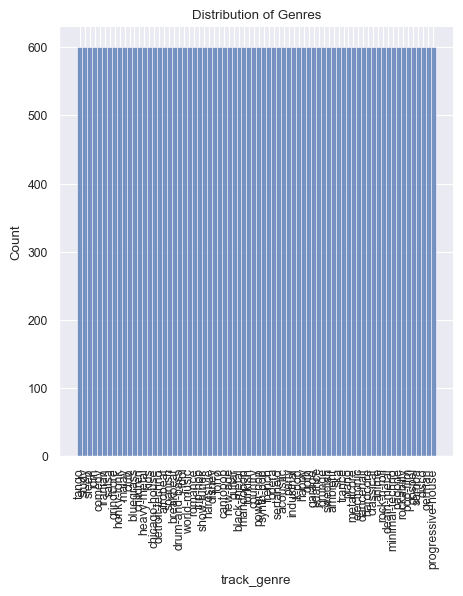

In [138]:
# Create an equal distribution of Genres

# Get list of genres that have more than 600 tracks
genre_counts = df['track_genre'].value_counts()
genre_list = genre_counts[genre_counts>600].index

# Filter data to only include genres from our new genre_list
df = df[df['track_genre'].isin(genre_list)]
print(df.shape)

# Truncate each genre to 600 tracks to create an equal distribution
cols = df.columns
df_cleaned = pd.DataFrame(columns=cols)

for genre in genre_list:
    df_cleaned = pd.concat([df_cleaned, df[df['track_genre'] == genre][0:600]], ignore_index=True)

# Plot the distribution of genres
sns.displot(df_cleaned['track_genre'])
sns.set_context("paper")
plt.title('Distribution of Genres')
plt.xticks(rotation=90)
plt.show()

### Feature Engineering

In [139]:
# Drop unncessary fields
df_cleaned = df_cleaned.drop(columns = ["track_id", "artists", "album_name","track_name","time_signature"])

# Map explicit field to binary
df_cleaned['explicit'] = df_cleaned['explicit'].apply(lambda x: 1 if x == True else 0)

# One hot encode key field
df_cleaned = pd.get_dummies(df_cleaned, columns=['key'], dtype=int)
df_cleaned = df_cleaned.rename(columns={"key_0":"C","key_1":"C#","key_2":"D","key_3":"D#","key_4":"E","key_5":"F",
                        "key_6":"F#","key_7":"G","key_8":"G#","key_9":"A","key_10":"A#","key_11":"B"})

print(df_cleaned.shape)
df_cleaned.head()

(43200, 26)


,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
0,32,123626,0,0.525,0.412,-13.790,0,0.0600,0.996,0.008260,0.404,0.672,82.111,tango,0,0,0,0,0,1,0,0,0,0,0,0
1,28,156223,0,0.435,0.349,-12.048,0,0.0598,0.875,0.010400,0.367,0.488,90.889,tango,0,0,0,0,0,0,1,0,0,0,0,0
2,37,266373,0,0.423,0.301,-11.091,1,0.2630,0.928,0.000005,0.212,0.389,72.184,tango,1,0,0,0,0,0,0,0,0,0,0,0
3,31,158533,0,0.479,0.218,-13.826,0,0.0406,0.981,0.939000,0.229,0.550,120.416,tango,0,0,1,0,0,0,0,0,0,0,0,0
4,28,221934,0,0.383,0.251,-13.056,1,0.0442,0.826,0.000000,0.115,0.140,78.434,tango,0,1,0,0,0,0,0,0,0,0,0,0


### Decision Trees

In [164]:
## REMOVING COLUMNS FOR TESTING MODEL PERFORMANCE ##
df_test = df_cleaned.drop(columns = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"])
# df_test = df_cleaned

In [165]:
# Load tracks and genre labels
tracks = df_test.drop(columns = ['track_genre'])
labels = df_test['track_genre']

print("Shape of images ", tracks.shape)
print("Shape of labels ", labels.shape)

Shape of images  (43200, 13)
Shape of labels  (43200,)


In [166]:
# Encode Labels
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

# Perform two consecutive train_test_splits to get train, val, and test data
X_train, X_test, y_train, y_test = train_test_split(tracks, encoded_labels, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

# Print shapes of train, val, and test data 
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (25920, 13)
Shape of train labels  (25920,)
Shape of val images  (8640, 13)
Shape of train labels  (8640,)
Shape of test images  (8640, 13)
Shape of test labels  (8640,)


In [167]:
# Build RandomForestClassifier, and fit with X_Train_re, y_train
rf = RandomForestClassifier(
    n_estimators=28,
    n_jobs=1,
    random_state=7,
    max_depth=10,
    # max_features='log2'
)
rf.fit(X_train, y_train)

# Evaluate model accuracy with X_train_re
print('Model Accuracy on training set:',round(rf.score(X_train, y_train),2))  

# Evaluate model accuracy with X_val_re
print('Model Accuracy on validation set:',round(rf.score(X_val, y_val),2))

# Plot Confusion Matrix using y_val, y_val_pred
# y_val_pred = rf.predict(X_val)
# cm = confusion_matrix(y_val, y_val_pred)
# confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix = cm) #, display_labels=label_list

# confusion_matrix_display.plot()
# plt.show()

Model Accuracy on training set: 0.55
Model Accuracy on validation set: 0.44


With the initial dataset, after some hyperparameter tuning, we were only able to get to around 28% validation accuracy. Upon some investigation, it became clear that there are some tracks that have multiple genres, which is confusing the model during training. We kept only the tracks with one labeled genre, and were able to increase the validation accuracy to 37%. However, removing the tracks with duplicate genres also distrubed the equal distribution of genres (originally 1000 tracks per genre). We then grabbed an equal number of tracks per genre above 600, and dropped all genres below this number. This resulted in a validation accuracy of 44%

In [168]:
importances = rf.feature_importances_
print('Important Features:',importances[importances>0].shape)
importances

Important Features: (13,)


array([0.22004213, 0.08949091, 0.01136152, 0.09794748, 0.06707246,
       0.07267975, 0.0100157 , 0.07847987, 0.10565732, 0.08653325,
       0.03305639, 0.07504833, 0.0526149 ])

Looks like all parameters have importance > 0. Should we try normalizing